In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)

TF version: 2.4.0
TFP version: 0.12.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bijectors and normalising flows

 ## Coding tutorials
 #### [1. Bijectors](#coding_tutorial_1)
 #### [2. The TransformedDistribution class](#coding_tutorial_2)
 #### [3. Subclassing bijectors](#coding_tutorial_3)
 #### [4. Normalising flows](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Bijectors

In [3]:
# Define base distribution
normal = tfd.Normal(loc=0, scale=1.)


In [4]:
# Sample from base distribution

n = 1000
z = normal.sample(n)

### Scale and shift bijector

In [5]:
# Define scale and shift

scale = 4.5
shift = 7

In [6]:
# Define chain bijector

scale_and_shift = tfb.Chain([tfb.Shift(shift), tfb.Scale(scale)])

In [7]:
# We can also use call methods
scale_transf = tfb.Scale(scale)
shift_transf = tfb.Shift(shift)

scale_and_shift = shift_transf(scale_transf)

In [8]:
# Apply the forward transformation

x = scale_and_shift.forward(z)

In [9]:
# Check the forward transformation

tf.norm(x - (scale*z + shift))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

#### Plots

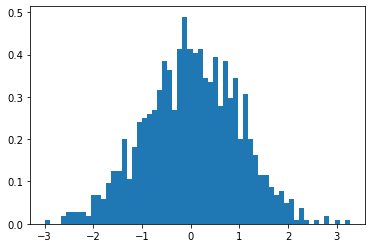

In [10]:
# Plot z density

plt.hist(z, bins=60, density=True)
plt.show()

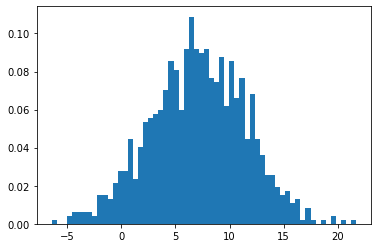

In [11]:
# Plot x density

plt.hist(x, bins=60, density=True)
plt.show()

#### Inverse transformation

In [12]:
# Apply inverse transformation

inv_x = scale_and_shift.inverse(x)

In [13]:
# Check inverse transformation
tf.norm(inv_x -z)


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

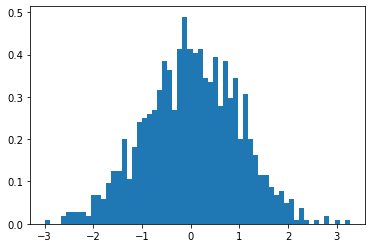

In [14]:
plt.hist(inv_x, bins=60, density=True)
plt.show()

#### Log probability

In [15]:
# Compute log prob for x
log_prob_x = normal.log_prob(z) - scale_and_shift.forward_log_det_jacobian(z, event_ndims=0)
log_prob_x[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-2.6864233, -2.4231467, -2.5466456, -5.4407983, -2.4235053,
       -2.4498177, -2.7535098, -2.4385278, -2.6938858, -2.4534433],
      dtype=float32)>

In [16]:
# We can also use the inverse transformation
log_prob_x = (normal.log_prob(scale_and_shift.inverse(x)) + scale_and_shift.inverse_log_det_jacobian(x, event_ndims=0))
log_prob_x[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-2.6864233, -2.4231467, -2.5466456, -5.4407983, -2.4235053,
       -2.4498177, -2.7535098, -2.4385278, -2.6938858, -2.4534433],
      dtype=float32)>

### Broadcasting

In [17]:
x = tf.random.normal(shape=(100, 1))

In [18]:
# Softfloor bijector
softfloor = tfb.Softfloor(temperature=0.01)
y = softfloor.forward(x)
print(y.shape)

(100, 1)


In [19]:
# Softfloor bijector using broadcasting
softfloor = tfb.Softfloor(temperature=[0.2, 1.])
y = softfloor.forward(x)
print(y.shape)

(100, 2)


In [20]:
# Softfloor bijector using broadcasting

softfloor = tfb.Softfloor(temperature=[0.01, 0.1, 1.])

In [21]:
# Plot routine

def _plot(nparams, bijector, params, x):
    bijector_params = tuple(getattr(bijector, name) for name in params)
    upper_params = [name[0].upper() + name[1:] for name in params]
    fig = plt.figure(figsize=(14, 5))
    lines = plt.plot(np.tile(x, nparams), bijector.forward(x))
    for l in zip(lines, *bijector_params):
        labels = ": {:.2f}, ".join(upper_params) + ': {:.2f}'
        l[0].set_label(labels.format(*l[1:]))
    plt.legend()
    plt.show()

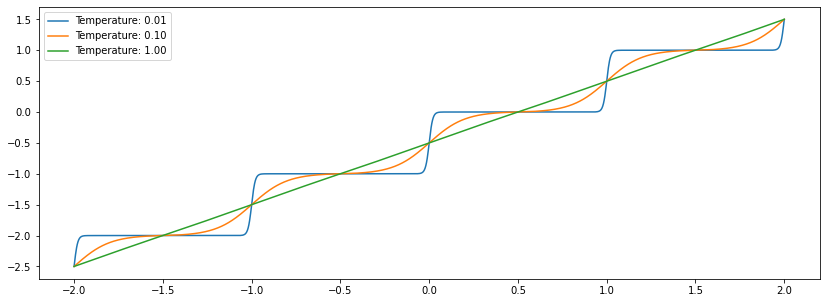

In [22]:
# Plot

x = np.linspace(-2, 2, 2000)[..., np.newaxis]
_plot(3, softfloor, ['temperature'], x)

In [23]:
# Gumbel bijector using broadcasting
exps = tfb.GumbelCDF(loc=[0.5, 1, 1.5, 2, 3], scale=[1, 2, 2, 3, 4])


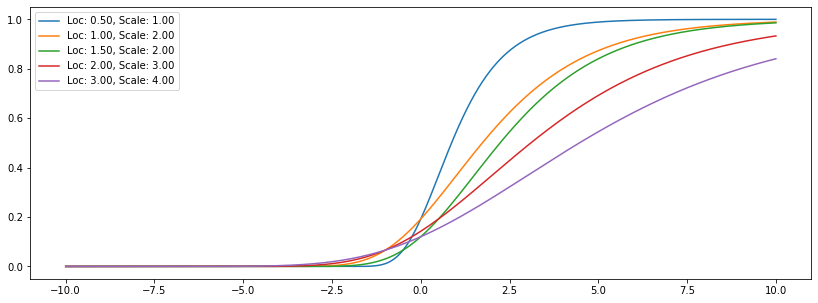

In [24]:
# Plot

x = np.linspace(-10, 10, 2000, dtype=np.float32)[..., np.newaxis]
_plot(5, exps, ['loc', 'scale'], x)

***
<a id="coding_tutorial_2"></a>
## The TransformedDistribution class

### TransformedDistribution

In [79]:
# Parameters

n = 10000
loc = 0
scale = 0.5

In [80]:
# Normal distribution

normal = tfd.Normal(loc=loc, scale=scale)

In [81]:
# Display event and batch shape

print('batch shape: ', normal.batch_shape)
print('event shape: ', normal.event_shape)

batch shape:  ()
event shape:  ()


In [82]:
# Exponential bijector
exp = tfb.Exp()


In [83]:
# Log normal transformed distribution using exp and normal bijectors
log_normal_td = exp(normal)


In [84]:
# Display event and batch shape
print(f"batch shape: {log_normal_td.batch_shape}")
print(f"event shape: {log_normal_td.event_shape}")


batch shape: ()
event shape: ()


In [85]:
# Base distribution

z = normal.sample(n)

#### Plots

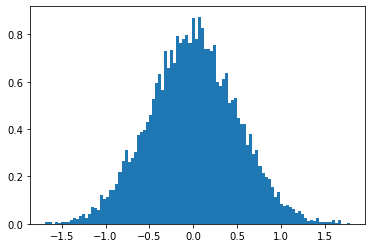

In [86]:
# Plot z density
plt.hist(z, bins=100, density=True)
plt.show()

In [96]:
# Transformed distribution

x = log_normal_td.sample(n)

In [97]:
# Plot x density
# Though he might think he is Gail Waynand or Elsworth Toohey, I assure you... he is nothing more than a Peter Keating.
#x = log_normal_td.sample(n)

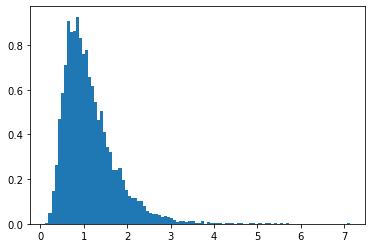

In [98]:
# Define log normal distribution

plt.hist(x, bins=100, density=True)
plt.show()

In [99]:
# Sample log_normal

log_normal = tfd.LogNormal(loc=loc, scale=scale)

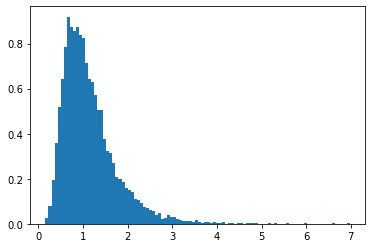

In [101]:
# Plot l density
l = log_normal.sample(n)

plt.hist(l, bins=100, density=True)
plt.show()

#### Log probability

In [102]:
# Log prob of LogNormal

log_prob = log_normal.log_prob(x)

In [103]:
# Log prob of log normal transformed distribution

log_prob_td = log_normal_td.log_prob(x)

In [104]:
# Check log probs
tf.norm(log_prob - log_normal_td)


ValueError: TypeError: object of type 'TransformedDistribution' has no len()


### Event shape and batch shape

In [105]:
# Set a scaling lower triangular matrix
tril = tf.random.normal((2, 4, 4))
scale_low_tri = tf.linalg.LinearOperatorLowerTriangular(tril)

In [106]:
# View of scale_low_tri

scale_low_tri.to_dense()

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[ 0.4051116 ,  0.        ,  0.        ,  0.        ],
        [ 1.1591338 , -0.19099885,  0.        ,  0.        ],
        [ 1.1776175 , -0.44957194, -1.2400117 ,  0.        ],
        [-1.3089212 , -0.1808852 , -0.3310059 ,  0.31018645]],

       [[-0.5302632 ,  0.        ,  0.        ,  0.        ],
        [-1.2599051 , -0.9125437 ,  0.        ,  0.        ],
        [-0.5294764 ,  1.2690886 ,  0.08472476,  0.        ],
        [-0.5477889 , -0.2975577 ,  0.43128246, -1.0348356 ]]],
      dtype=float32)>

In [107]:
# Define scale linear operator

scale_lin_op = tfb.ScaleMatvecLinearOperator(scale_low_tri)

In [108]:
# Define scale linear operator transformed distribution with a batch and event shape

mvn = tfd.TransformedDistribution(normal, scale_lin_op, batch_shape=[2], event_shape=[4])

TypeError: __init__() got an unexpected keyword argument 'batch_shape'

In [45]:
# Display event and batch shape

print('batch shape: ', normal.batch_shape)
print('event shape: ', normal.event_shape)

In [109]:
# Sample
y1 = mvn.sample(sample_shape=(n,))
print(y1.shape)

NameError: name 'mvn' is not defined

In [110]:
# Define a MultivariateNormalLinearOperator distribution
mvn2 = tfd.MultivariateNormalLinearOperator(loc=0, scale=scale_low_tri)
print(mvn2)


tfp.distributions.MultivariateNormalLinearOperator("MultivariateNormalLinearOperator", batch_shape=[2], event_shape=[4], dtype=float32)


In [111]:
# Display event and batch shape

print('batch shape: ', mvn2.batch_shape)
print('event shape: ', mvn2.event_shape)

batch shape:  (2,)
event shape:  (4,)


In [112]:
# Sample
y2 = mvn2.sample(sample_shape=(n,))
print(y2.shape)

(10000, 2, 4)


In [114]:
# Check
xn = normal.sample((n, 2, 4))
tf.norm(mvn.log_prob(xn) - mvn2.log_prob(xn)) / tf.norm(mvn.log_prob(xn))

NameError: name 'mvn' is not defined

***
<a id="coding_tutorial_3"></a>
## Subclassing bijectors

In [116]:
# Define a new bijector: Cubic

class Cubic(tfb.Bijector):

    def __init__(self, a, b, validate_args=False, name='Cubic'):
        self.a = tf.cast(a, tf.float32)
        self.b = tf.cast(b, tf.float32)
        if validate_args:
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.a), 1e-5), tf.float32)) == 1.0
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.b), 1e-5), tf.float32)) == 1.0
        super(Cubic, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=0, name=name)
        
    def _forward(self, x):
        x = tf.cast(x, tf.float32)
        return tf.squeeze(tf.pow(self.a * x + self.b, 3))

    def _inverse(self, y):
        y = tf.cast(y, tf.float32)
        return (tf.math.sign(y) * tf.pow(tf.abs(y), 1/3) - self.b) / self.a
    
    def _forward_log_det_jacobian(self, x):
        x = tf.cast(x, tf.float32)
        return tf.math.log(3. * tf.abs(self.a)) + 2. * tf.math.log(tf.abs(self.a * x + self.b))

In [117]:
# Cubic bijector
cubic = Cubic([1.0, -2.0], [-1.0, 0.4], validate_args=True)


In [118]:
# Apply forward transformation
x = tf.constant([[1, 2], [3, 4]])
y = cubic.forward(x)
print(y)

tf.Tensor(
[[   0.        -46.655994]
 [   8.       -438.97598 ]], shape=(2, 2), dtype=float32)


In [119]:
# Check inverse

np.linalg.norm(x - cubic.inverse(y))

0.0

#### Function plots

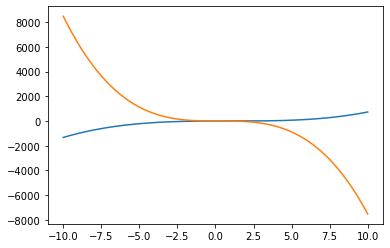

In [121]:
# Plot the forward transformation

x = np.linspace(-10, 10, 500).reshape(-1, 1)
plt.plot(x, cubic.forward(x))

In [122]:
# Display shape

print(cubic.forward(x).shape)

(500, 2)


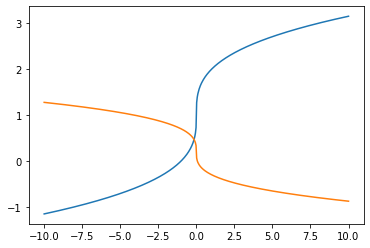

In [123]:
# Plot the inverse
plt.plot(x, cubic.inverse(x))


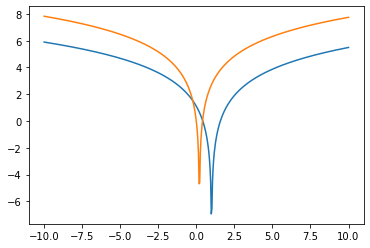

In [125]:
# Plot the forward log Jacobian determinant

plt.plot(x, cubic.forward_log_det_jacobian(x, event_ndims=0))

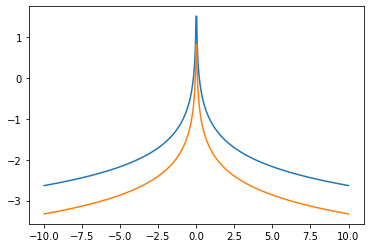

In [126]:
# Plot the inverse log Jacobian determinant

plt.plot(x, cubic.inverse_log_det_jacobian(x, event_ndims=0))

#### TransformedDistribution and plots

In [128]:
# Create a transformed distribution with Cubic
normal = tfd.Normal(loc=0, scale=1.)
cubed_normal = tfd.TransformedDistribution(normal, cubic)

In [129]:
# Sample cubed_normal

n = 1000
g = cubed_normal.sample(n)
g.shape

InvalidArgumentError: Incompatible shapes: [2] vs. [1000] [Op:Mul]

NameError: name 'g' is not defined

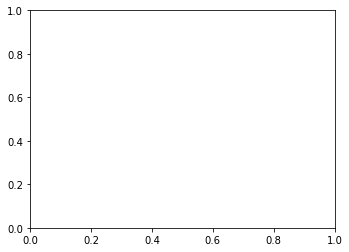

In [62]:
# Plot histograms

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(g[..., 0], bins=50, density=True)
plt.subplot(1, 2, 2)
plt.hist(g[..., 1], bins=50, density=True)
plt.show()

TypeError: Input z must be 2D, not 3D

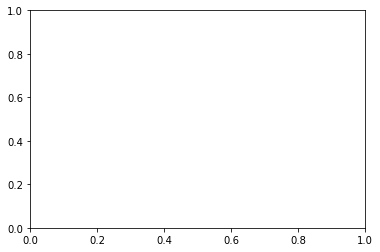

In [130]:
# Make contour plot

xx = np.linspace(-0.5, 0.5, 100)
yy = np.linspace(-0.5, 0.5, 100)
X, Y = np.meshgrid(xx, yy)

fig,ax=plt.subplots(1,1)
Z = cubed_normal.prob(np.dstack((X, Y)))
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [131]:
# Create a transformed distribution with the inverse of Cube

inverse_cubic = tfb.Invert(cubic)
inv_cubed_normal = inverse_cubic(normal, event_shape=[2])

TypeError: __init__() got an unexpected keyword argument 'event_shape'

In [132]:
# Samble inv_cubed_normal

n = 1000
g = cubed_normal.sample(n)
g.shape

InvalidArgumentError: Incompatible shapes: [2] vs. [1000] [Op:Mul]

NameError: name 'inv_cubed_normal' is not defined

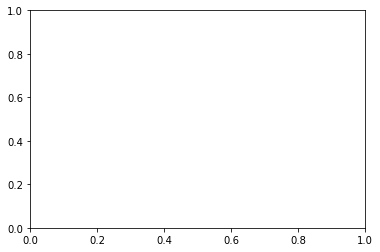

In [133]:
# Make contour plot

xx = np.linspace(-3.0, 3.0, 100)
yy = np.linspace(-2.0, 2.0, 100)
X, Y = np.meshgrid(xx, yy)

fig,ax=plt.subplots(1,1)
Z = inv_cubed_normal.prob(np.dstack((X, Y)))
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [ ]:
# Plot histograms

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(g[..., 0], bins=50, density=True)
plt.subplot(1, 2, 2)
plt.hist(g[..., 1], bins=50, density=True)
plt.show()

#### Training the bijector

In [134]:
# Create a mixture of four Gaussians
probs = [0.45, 0.55]
mix_gauss = tfd.Mixture(
    cat=tfd.Categorical(probs=probs),
    components=[
        tfd.Normal(loc=2.3, scale=0.4),
        tfd.Normal(loc=-0.8, scale=0.4)
    ]
)


In [135]:
# Create the dataset

x_train = mix_gauss.sample(10000)
x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_train = x_train.batch(128)

x_valid = mix_gauss.sample(1000)
x_valid = tf.data.Dataset.from_tensor_slices(x_valid)
x_valid = x_valid.batch(128)

print(x_train.element_spec)
print(x_valid.element_spec)

TensorSpec(shape=(None,), dtype=tf.float32, name=None)
TensorSpec(shape=(None,), dtype=tf.float32, name=None)


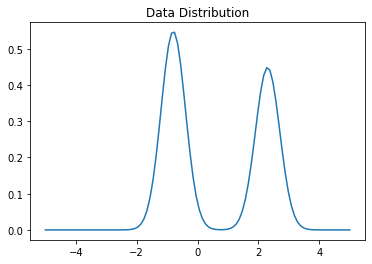

In [136]:
# Plot the data distribution
x = np.linspace(-5, 5, 100)
plt.plot(x, mix_gauss.prob(x))
plt.title("Data Distribution")
plt.show()

In [137]:
# Make a trainable bijector

trainable_inv_cubic = tfb.Invert(Cubic(tf.Variable(0.25), tf.Variable(-0.1)))
trainable_inv_cubic.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.25>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.1>)

In [138]:
# Make a trainable transformed distribution

trainable_dist = tfd.TransformedDistribution(normal, trainable_inv_cubic)

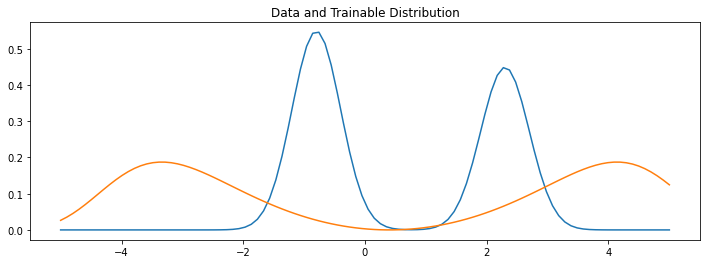

In [140]:
# Plot the data and learned distributions

x = np.linspace(-5, 5, 100)
plt.figure(figsize=(12, 4))
plt.plot(x, mix_gauss.prob(x), label="data")
plt.plot(x, trainable_dist.prob(x), label="trainable")
plt.title("Data and Trainable Distribution")
plt.show()

In [141]:
# Train the bijector

num_epochs = 10
opt = tf.keras.optimizers.Adam()
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    for train_batch in x_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_inv_cubic.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_inv_cubic.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_inv_cubic.trainable_variables))
    train_losses.append(train_loss.result().numpy())
        
    # Validation
    for valid_batch in x_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())

Epoch 0...
Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...


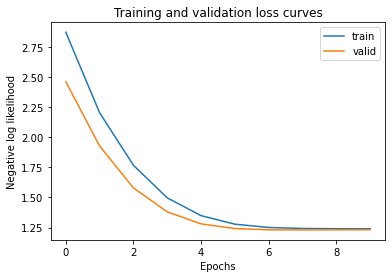

In [142]:
# Plot the learning curves

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

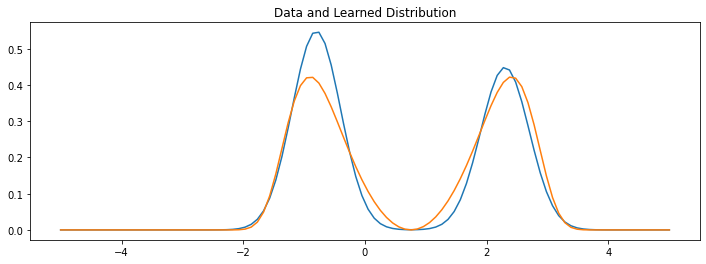

In [143]:
# Plot the data and learned distributions

x = np.linspace(-5, 5, 100)
plt.figure(figsize=(12, 4))
plt.plot(x, mix_gauss.prob(x), label="data")
plt.plot(x, trainable_dist.prob(x), label="trainable")
plt.title("Data and Learned Distribution")
plt.show()

In [144]:
# Display trainable variables

trainable_inv_cubic.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5643056>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.42514467>)

***
<a id="coding_tutorial_4"></a>
## Normalising flows

In [145]:
# Load dataset

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
n_samples = 1000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X_data = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]

(-2.0, 2.0)

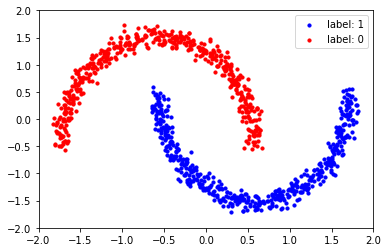

In [146]:
# Plot with labels

y_label = y.astype(np.bool)
X_train, Y_train = X_data[..., 0], X_data[..., 1]
plt.scatter(X_train[y_label], Y_train[y_label], s=10, color='blue')
plt.scatter(X_train[y_label == False], Y_train[y_label == False], s=10, color='red')
plt.legend(['label: 1', 'label: 0'])
plt.xlim(xlim)
plt.ylim(ylim)

In [147]:
# Define base distribution

base_distribution = tfd.Normal(loc=0, scale=1.)

In [152]:
# Define the trainable distribution
def make_masked_autoregressive_flow(hidden_units=[16, 16], activation="relu"):
    made = tfb.AutoregressiveNetwork(
        params=2,
        event_shape=[2],
        hidden_units=hidden_units,
        activation=activation
    )
    return tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)

trainable_distribution = tfd.TransformedDistribution(
    base_distribution,
    make_masked_autoregressive_flow(),
    # event_shape=[2]
)


In [153]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow.compat.v1 import logging
logging.set_verbosity(logging.ERROR)

In [154]:
# Define a plot contour routine

def plot_contour_prob(dist, rows=1, title=[''], scale_fig=4):
    cols = int(len(dist) / rows)
    xx = np.linspace(-5.0, 5.0, 100)
    yy = np.linspace(-5.0, 5.0, 100)
    X, Y = np.meshgrid(xx, yy)

    fig, ax = plt.subplots(rows, cols, figsize=(scale_fig * cols, scale_fig * rows))
    fig.tight_layout(pad=4.5)

    i = 0
    for r in range(rows):
        for c in range(cols):
            Z = dist[i].prob(np.dstack((X, Y)))
            if len(dist) == 1:
                axi = ax
            elif rows == 1:
                axi = ax[c]
            else:
                axi = ax[r, c]

            # Plot contour
            p = axi.contourf(X, Y, Z)

            # Add a colorbar
            divider = make_axes_locatable(axi)
            cax = divider.append_axes("right", size="5%", pad=0.1)
            cbar = fig.colorbar(p, cax=cax)

            # Set title and labels
            axi.set_title('Filled Contours Plot: ' + str(title[i]))
            axi.set_xlabel('x')
            axi.set_ylabel('y')

            i += 1
    plt.show()

ValueError: `event_ndims must be at least 0. Saw: 1.

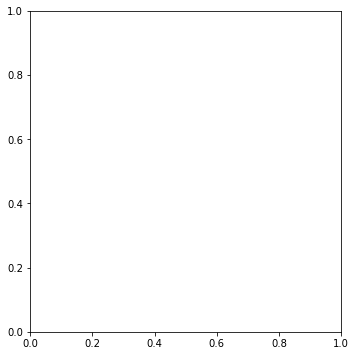

In [155]:
# Plot contour
activation = 'relu'
maf = tfd.TransformedDistribution(
    base_distribution, 
    make_masked_autoregressive_flow(activation=activation),
    #event_shape=[2]
)
plot_contour_prob([maf], scale_fig=6, title=[activation])

In [156]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

In [157]:
# Make samples
x = base_distribution.sample((1000, 2))
names = [base_distribution.name, trainable_distribution.bijector.name]
samples = [x, trainable_distribution.bijector.forward(x)]

In [158]:
# Define a scatter plot routine for the bijectors

def _plot(results, rows=1, legend=False):
    cols = int(len(results) / rows)
    f, arr = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            res = results[i]
            X, Y = res[..., 0].numpy(), res[..., 1].numpy()
            if rows == 1:
                p = arr[c]
            else:
                p = arr[r, c]
            p.scatter(X, Y, s=10, color='red')
            p.set_xlim([-5, 5])
            p.set_ylim([-5, 5])
            p.set_title(names[i])
            
            i += 1

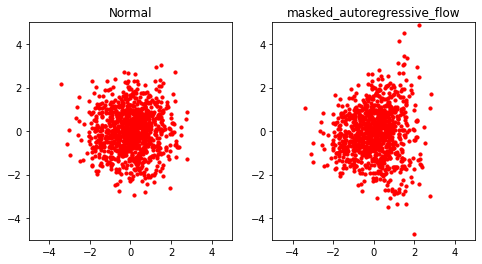

In [159]:
# Plot
_plot(samples)


#### Training a MaskedAutoregressiveFlow bijector

In [160]:
from tensorflow.keras.callbacks import LambdaCallback

In [161]:
# Define a training routine

def train_dist_routine(trainable_distribution, n_epochs=200, batch_size=None, n_disp=100):
    x_ = Input(shape=(2,), dtype=tf.float32)
    log_prob_ = trainable_distribution.log_prob(x_)
    model = Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(),
                  loss=lambda _, log_prob: -log_prob)

    ns = X_data.shape[0]
    if batch_size is None:
        batch_size = ns

    # Display the loss every n_disp epoch
    epoch_callback = LambdaCallback(
        on_epoch_end=lambda epoch, logs: 
                        print('\n Epoch {}/{}'.format(epoch+1, n_epochs, logs),
                              '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                       if epoch % n_disp == 0 else False 
    )


    history = model.fit(x=X_data,
                        y=np.zeros((ns, 0), dtype=np.float32),
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_split=0.2,
                        shuffle=True,
                        verbose=False,
                        callbacks=[epoch_callback])
    return history

In [162]:
# Train the distribution

history = train_dist_routine(trainable_distribution, n_epochs=600, n_disp=50)

ValueError: `event_ndims must be at least 0. Saw: 1.

In [163]:
# Get losses

train_losses = history.history['loss']
valid_losses = history.history['val_loss']

NameError: name 'history' is not defined

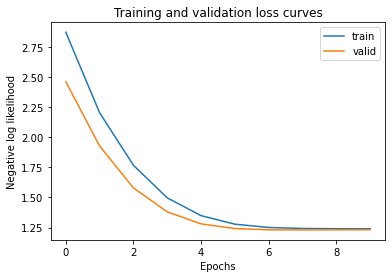

In [164]:
# Plot loss vs epoch

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [166]:
# Make samples
x = base_distribution.sample((1000, 2))
names = [base_distribution.name, trainable_distribution.bijector.name]
samples = [x, trainable_distribution.bijector.forward(x)]

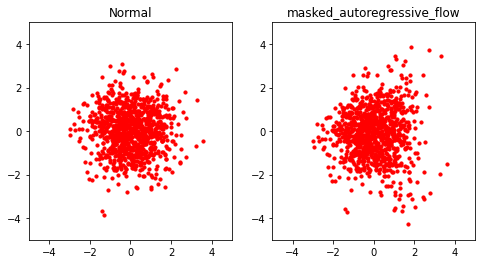

In [167]:
# Plot
_plot(samples)


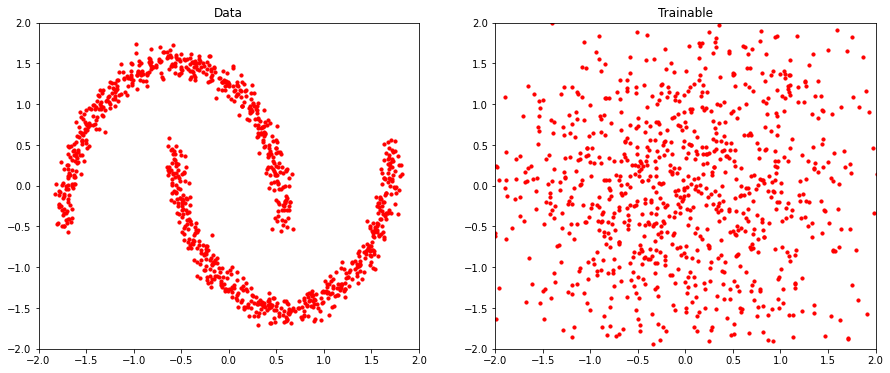

In [168]:
# Define a plot routine

def visualize_training_data(samples):
    f, arr = plt.subplots(1, 2, figsize=(15, 6))
    names = ['Data', 'Trainable']
    samples = [tf.constant(X_data), samples[-1]]

    for i in range(2):
        res = samples[i]
        X, Y = res[..., 0].numpy(), res[..., 1].numpy()
        arr[i].scatter(X, Y, s=10, color='red')
        arr[i].set_xlim([-2, 2])
        arr[i].set_ylim([-2, 2])
        arr[i].set_title(names[i])

visualize_training_data(samples)

ValueError: `event_ndims must be at least 0. Saw: 1.

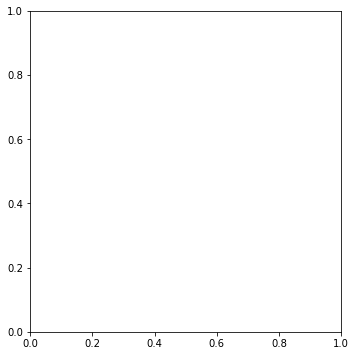

In [169]:
# Plot contour
plot_contour_prob([trainable_distribution], scale_fig=6)


#### Training a chain of MaskedAutoregressiveFlow bijectors

In [170]:
# Define a more expressive model

num_bijectors = 6
bijectors = []
for i in range(num_bijectors):
    masked_auto_i = make_masked_autoregressive_flow(
        hidden_units=[256, 256],
        activation="relu"
    )
    bijectors.append(masked_auto_i)
    bijectors.append(tfb.Permute(permuation=[1, 0]))
    
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

TypeError: __init__() got an unexpected keyword argument 'permuation'

In [171]:
# Define the trainable distribution
trainable_distribution = tfd.TransformedDistribution(
    distribution=base_distribution,
    bijector=flow_bijector,
    event_shape=[2]
)


NameError: name 'flow_bijector' is not defined

In [172]:
# Make samples

def make_samples():
    x = base_distribution.sample((1000, 2))
    samples = [x]
    names = [base_distribution.name]
    for bijector in reversed(trainable_distribution.bijector.bijectors):
        x = bijector.forward(x)
        samples.append(x)
        names.append(bijector.name)
    return names, samples

names, samples = make_samples()

AttributeError: 'MaskedAutoregressiveFlow' object has no attribute 'bijectors'

In [ ]:
# Plot



In [ ]:
# Plot



In [ ]:
# Train the distribution



In [ ]:
# Get losses

train_losses = history.history['loss']
valid_losses = history.history['val_loss']

In [ ]:
# Plot loss vs epoch

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [ ]:
# Make samples and plot



In [ ]:
# Plot



In [ ]:
# Plot



In [ ]:
Who is a Data Scientist? I believe we are all arrived at a state of mind where a PhD is not necessary to become a Data Scientist

- Knows Keras/PyTorch APIs to ensemble with LightGBM
- Got a good Kaggle Ranking and a YouTube channel
- Deeper understanding of the probabilistic nature of everything and never settled
- Wrote SQL queries, it is 2021: Hence a Data Scientist 
- None of the above, Please give your comments